In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
sns.set_color_codes()

In [2]:
# load data
d = pd.read_csv('data/wafflehouse_divorce.csv')
# standardize predictor
d['median_age_marriage_s'] = (d.median_marriage_age - 
                              d.median_marriage_age.mean()) / d.median_marriage_age.std()
d['marriage_rate_s'] = (d.marriage_rate - d.marriage_rate.mean())/ d.marriage_rate.std()

In [3]:
d.head().T

,0,1,2,3,4
location,Alabama,Alaska,Arizona,Arkansas,California
loc,AL,AK,AZ,AR,CA
population,4.78,0.71,6.33,2.92,37.25
median_marriage_age,25.3,25.2,25.8,24.3,26.8
marriage_rate,20.2,26,20.3,26.4,19.1
marriage_rate_se,1.27,2.93,0.98,1.7,0.39
divorce_rate,12.7,12.5,10.8,13.5,8
divorce_rate_se,0.79,2.05,0.74,1.22,0.24
wafflehouses,128,0,18,41,0
is_south,1,0,0,1,0


# Multivariate Linear Models

Modeling Divorce Rate as a function of Age at marriage and rate of marriage
\begin{align}
D_i & \sim Normal(\mu_i, \sigma) \\
\mu_i & = \alpha + \beta_A age_i + \beta_R rate_i \\
\alpha & \sim Normal(10, 10) \\ 
\beta_A & \sim Normal(0, 1) \\
\beta_R & \sim Normal(0, 1) \\
\sigma & \sim Uniform(0, 10) \\
\end{align}

In [4]:
with pm.Model() as multi_linear:
    alpha = pm.Normal('alpha', mu=10, sd=10)
    beta_a = pm.Normal('beta_a', mu=0, sd=1)
    beta_r = pm.Normal('beta_r', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = alpha + beta_a * d.median_age_marriage_s + beta_r * d.marriage_rate_s
    divorce_hat = pm.Normal('divorce_hat', mu, sigma, observed=d.divorce_rate)
    divorce_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:02<00:00, 553.86it/s]


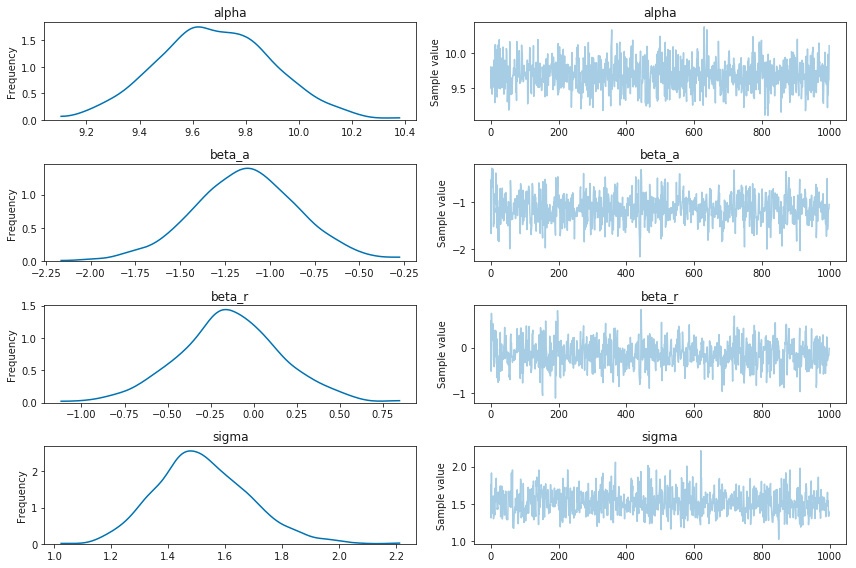

In [5]:
pm.traceplot(divorce_trace);

In [6]:
divorce_trace_df = pm.trace_to_dataframe(divorce_trace)

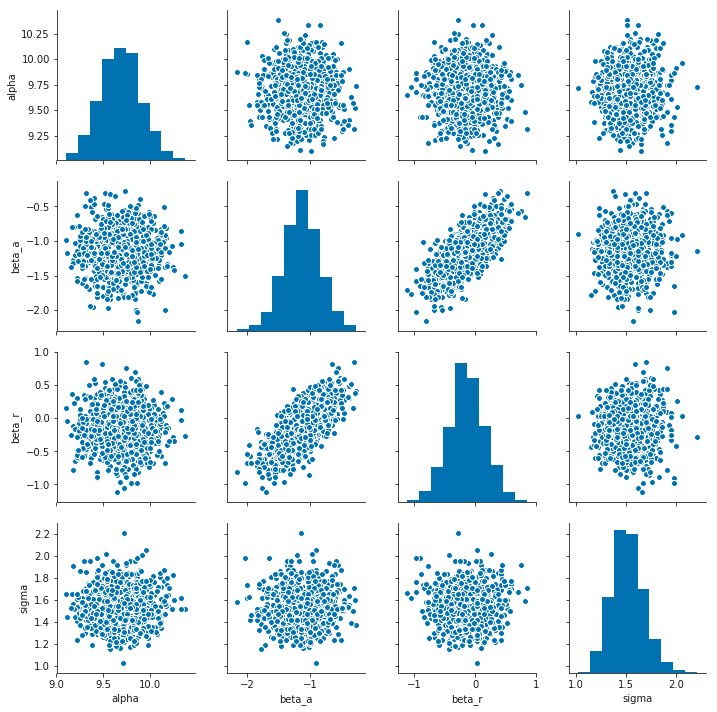

In [7]:
sns.pairplot(divorce_trace_df);

In [8]:
divorce_trace_df.corr().round(2)

,alpha,beta_a,beta_r,sigma
alpha,1.00,-0.01,-0.01,0.00
beta_a,-0.01,1.00,0.68,0.03
beta_r,-0.01,0.68,1.00,0.01
sigma,0.00,0.03,0.01,1.00


In [9]:
pm.hpd(divorce_trace_df.as_matrix())

array([[  9.2745924 ,  10.11711502],
       [ -1.73143995,  -0.56239563],
       [ -0.68244445,   0.48326162],
       [  1.22204816,   1.84260869]])

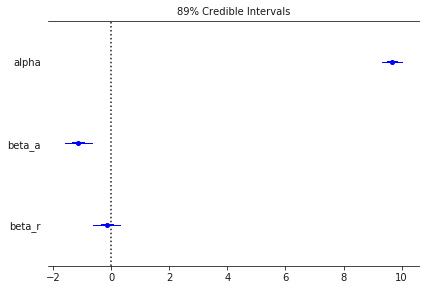

In [10]:
pm.forestplot(divorce_trace, ['alpha', 'beta_a', 'beta_r'], alpha=0.11);

In [11]:
grid = np.linspace(-2, 2, 100)

def get_marginal_mu_and_prediction_hpds(trace_df, grid, weights):
    mu_means = np.zeros(len(grid))
    mu_hpds = np.zeros((len(grid), 2))
    divorce_hpds = np.zeros((len(grid), 2))

    for i, v in enumerate(grid):
        mus = (
            trace_df['alpha'] 
            + trace_df['beta_a'] * weights['beta_a'] * grid[i]
            + trace_df['beta_r'] * weights['beta_r'] * grid[i]
        )
        divorce_predictions = stats.norm.rvs(loc=mus, scale=trace_df['sigma'])

        mu_means[i] =  mus.mean()
        mu_hpds[i, :] = pm.hpd(mus, 0.11)
        divorce_hpds[i, :] = pm.hpd(divorce_predictions, 0.11)
    return mu_means, mu_hpds, divorce_hpds

mu_means_a, mu_hpds_a, divorce_hpds_a = get_marginal_mu_and_prediction_hpds(
    divorce_trace_df, grid, {'beta_a': 1, 'beta_r': 0})

mu_means_r, mu_hpds_r, divorce_hpds_r = get_marginal_mu_and_prediction_hpds(
    divorce_trace_df, grid, {'beta_a': 0, 'beta_r': 1})

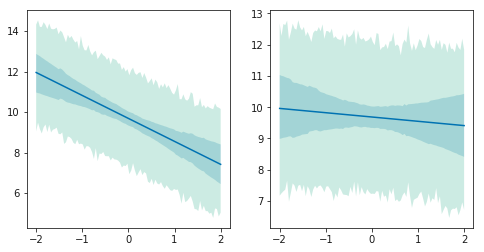

In [12]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4));
ax0.plot(grid, mu_means_a);
ax0.fill_between(grid, mu_hpds_a[:, 0], mu_hpds_a[:, 1], alpha=0.2);
ax0.fill_between(grid, divorce_hpds_a[:, 0], divorce_hpds_a[:, 1], alpha=0.2);

ax1.plot(grid, mu_means_r);
ax1.fill_between(grid, mu_hpds_r[:, 0], mu_hpds_r[:, 1], alpha=0.2);
ax1.fill_between(grid, divorce_hpds_r[:, 0], divorce_hpds_r[:, 1], alpha=0.2);
#FIXME: share y-axis


In [13]:
divorce_pred = pm.sample_ppc(divorce_trace, samples=1000, model=multi_linear)['divorce_hat']

100%|██████████| 1000/1000 [00:01<00:00, 594.76it/s]


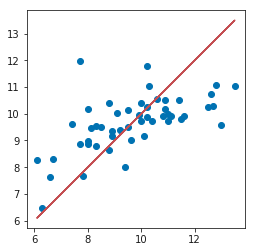

In [14]:
plt.scatter(d.divorce_rate, divorce_pred.mean(0))
plt.plot(d.divorce_rate, d.divorce_rate,'r-');
plt.gca().set_aspect('equal', adjustable='box');

In [15]:
d2 = d.loc[:, ('divorce_rate', 'loc')].copy()

In [16]:
d2['divorce_hat'] = divorce_pred.mean(0)

In [17]:
d2['divorce_hpd_min'] = pm.hpd(divorce_pred)[:, 0]
d2['divorce_hpd_max'] = pm.hpd(divorce_pred)[:, 1]

In [18]:
d2.sort_values('divorce_rate').head()

,divorce_rate,loc,divorce_hat,divorce_hpd_min,divorce_hpd_max
29,6.1,NJ,8.279974,5.271805,11.151885
8,6.3,DC,6.485311,2.789947,9.583204
31,6.6,NY,7.621213,4.415961,10.561252
6,6.7,CT,8.288540,4.927107,11.280723
23,7.4,MN,9.608913,6.303946,12.622090


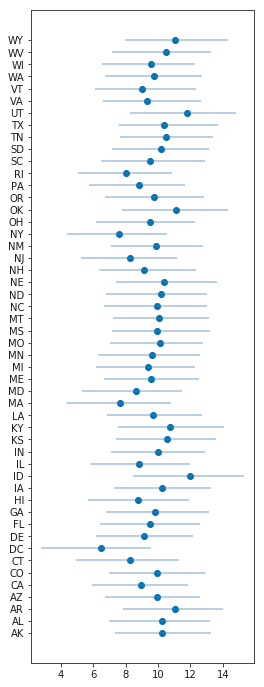

In [20]:
plt.figure(figsize=(4, 12));
plt.scatter(d2['divorce_hat'], d2['loc']);
plt.hlines(d2['loc'], d2['divorce_hpd_min'], d2['divorce_hpd_max'], color='steelblue', alpha=0.5);